In [1]:
from google.colab import drive
drive.mount('/mydrive')

Drive already mounted at /mydrive; to attempt to forcibly remount, call drive.mount("/mydrive", force_remount=True).


# *Project*:  Power line fault detection using Machine Learning and Deep Learning.

# I. Exploring the dataset.

* We wil be using API Pyarrow to load the .parquet training dataset. 
* The loaded dataset is then converted into a pandas dataframe which is then transposed, since .parquet stores data in columnar way.
* We will also be loading targets which are present in a different file 'metadata_train.csv'.

In [ ]:
import pyarrow.parquet as pq
import pandas as pd

data = pq.read_pandas('D://Professional//CDAC//COURSE STARTED//Project//train.parquet').to_pandas().transpose()

labels=pd.read_csv('D://Professional//CDAC//COURSE STARTED//Project//metadata_train.csv', header='infer')
target=labels[['target','phase']]
a=labels

storing index values of 0's and 1's to know if a tuple(which is a measurement per phase) has partial discharge or not. 
* Target (Class) 0 - Normal Signal
* Target (Class) 1 - Has partial Discharge

In [ ]:
target1=a.loc[a['target']==1].index.values[0:]
target0=a.loc[a['target']==0].index.values[0:]

* A single signal is composed of 3 phases. We notice that not all three phases of a signal share the same target value.
* So, even if one phase has a target value 1, we will be considering the entire signal as damaged(or partial discharge exists)

In [ ]:
i=0
target_category = []
while(i!=len(target)):
    temp=target['target'][i]+target['target'][i+1]+target['target'][i+2]
    if(temp>=1):
        target_category.append([i,i+1,i+2])
    
    temp=0
    i=i+3

flat_list = [item for sublist in target_category for item in sublist]

Above created list which has the new index positions will be used to separate data from the dataset. These tuples will be stored into two new lists.

In [ ]:
df_1s = []
df_0s = []
for i in range(0,len(data)):
    if i in flat_list:
        df_1s.append(data.iloc[i])
    else:
        df_0s.append(data.iloc[i])

# II) Generating signal Images.

* Every three consecutive phases will be plotted and saved.

* Saving figures of target 1.

In [ ]:
%matplotlib inline
import pylab as plt

def new1(l1):
    i=0
    fig=plt.figure(frameon=False)
    while(i!=len(l1)):
        fig.clf()
        p1=l1[i]
        p2=l1[i+1]
        p3=l1[i+2]
        plt.plot(p1)
        plt.plot(p2)
        plt.plot(p3)
        plt.axis('off')
        plt.savefig('D://Professional//CDAC//COURSE STARTED//Project//full//with1thresh//class1//sample_1_'+str(i)+".png")
        i=i+3
        
        
new1(df_1s)

Saving figures of target 0.

In [ ]:
%matplotlib inline
import pylab as plt

def new1(l1):
    i=0
    fig=plt.figure(frameon=False)
    while(i!=len(l1)):
        fig.clf()
        p1=l1[i]
        p2=l1[i+1]
        p3=l1[i+2]
        
        plt.plot(p1)
        plt.plot(p2)
        plt.plot(p3)
        plt.axis('off')
        
        plt.savefig('D://Professional//CDAC//COURSE STARTED//Project//full//with1thresh//class0//sample_0_'+str(i)+".png")
        i=i+3
        
        
new1(df_0s)

Storing the paths of all the images. 
* Path1 has directory of the images corresponding to target1. 
* path2 has directory of the images corresponding to target0.
* path3 has directory to which images will be saved after getting preprocessed.

In [ ]:
path1='D://Professional//CDAC//COURSE STARTED//Project//full//with1thresh//class0'
path2='D://Professional//CDAC//COURSE STARTED//Project//full//with1thresh//class1'
path3='D://Professional//CDAC//COURSE STARTED//Project//full//with1thresh//preprocessed'

Creating lists of image names.

In [ ]:
import os
from PIL import Image

listing0=os.listdir(path1)
listing1=os.listdir(path2)

Resizing the image and storing it in path3 which is supposed to store preprocessed images.

In [ ]:
for file in listing0:
    im=Image.open(path1 + '\\' + file)
    img=im.resize((256,256))
    gray=img.convert('L')
    gray.save(path3 + '\\' + file, "JPEG")

In [ ]:
for file in listing1:
    im=Image.open(path2 + '\\' + file)
    img=im.resize((256,256))
    gray=img.convert('L')
    gray.save(path3 + '\\' + file, "JPEG")
    

In [ ]:
imlist=os.listdir(path3)

Connecting colab to google drive. Extracting data to a specific folder.

In [0]:

import zipfile
zip_ref = zipfile.ZipFile("/mydrive/My Drive/Project/preprocessedwith1thresh.zip", 'r')
zip_ref.extractall("/content/data1")
zip_ref.close()

In [0]:
import os
a=os.listdir('/content/data1')

Since initially we don't know the index locations of the classes(0 & 1), we will be distinguishing the images corresponding to class 1 only.

To do this, we will 
* first generate a list of strings which match with the image names we are trying to find out the index locations of.
* We then run a loop and if a match is found between the real directory containing images and the list previously created, we will be collecting index locations of the image names corresponding to class 1.

In [0]:
#Step 1
list1=[]
for i in range(0,580):
    if i%3==0:
        list1.append('sample_1_'+str(i)+'.png')

#Step 2        
list2=[]
for i in range(0,len(a)):
      if a[i] in list1:
        list2.append(i)

Importing necessary APIs

In [6]:
# For controlling Python warnings - https://docs.python.org/3.6/library/warnings.html
import warnings
warnings.filterwarnings("ignore")

# For iterators - https://docs.python.org/3.1/library/itertools.html
import itertools

# For loading and handling data
import numpy as np
import pandas as pd

# For Normalization
from sklearn.preprocessing import MinMaxScaler

# For constructing DNN
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
from keras.layers import Input,Dropout,Dense 
from keras.models import Model
from keras import regularizers
from keras.utils.data_utils import get_file

# For visualization
import matplotlib.pyplot as plt

# For evaluating the accuracy
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,precision_score,f1_score
%matplotlib inline
import os
from PIL import Image

Using TensorFlow backend.


In [0]:
from numpy import *
path1='/content/data1'
imlist=os.listdir(path1)
num_samples=size(imlist)

Loading image data and creating a matrix vectors out of them

# III) Dealing with class Imbalance problem

In [0]:
immatrix=array([array(Image.open('/content/data1' + '/' + im2)).flatten() for im2 in imlist], 'f')

Creating an array of size equal to the row size of the data with initial values 1. We will then use the index locations which we found out earlier to change these label values to either 0 (if index of the new loop does not match with label) or 1 (if index of the new loop matches with the label)

In [0]:
labels=np.ones((num_samples,), dtype=int)

In [0]:
for i in range(0,len(labels)):
  if i in list2:
    labels[i]=1
  else:
    labels[i]=0

Creating a dataframe.

In [0]:

df1=pd.DataFrame(immatrix)

In [0]:
defi=labels.tolist()
df1['class']=labels

In [16]:
df1.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,65497,65498,65499,65500,65501,65502,65503,65504,65505,65506,65507,65508,65509,65510,65511,65512,65513,65514,65515,65516,65517,65518,65519,65520,65521,65522,65523,65524,65525,65526,65527,65528,65529,65530,65531,65532,65533,65534,65535,class
0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,0
1,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,0
2,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,0


Class imbalance

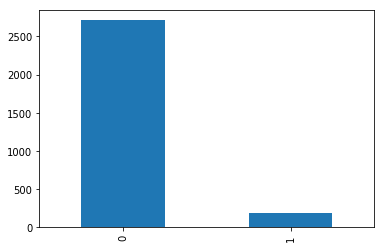

In [0]:
pd.Series(df1.iloc[:,-1]).value_counts().plot.bar()

In [18]:
df1['class'].value_counts()/len(df1)

0    0.933196
1    0.066804
Name: class, dtype: float64

Separating data and targets columns

In [0]:
X=np.array(df1.loc[:,df1.columns!='class'])
y=np.array(df1.loc[:,df1.columns=='class']).reshape(-1,1)

Scaling data

In [0]:
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
X=scaler.fit_transform(X)

In [0]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.33,random_state=2, shuffle=True,stratify=y)

Oversampling using SMOTE.

In [22]:
from imblearn.over_sampling import SMOTE

sm=SMOTE(random_state=33)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
X_train_new, y_train_new=sm.fit_sample(X_train,y_train.ravel())

Balanced data.

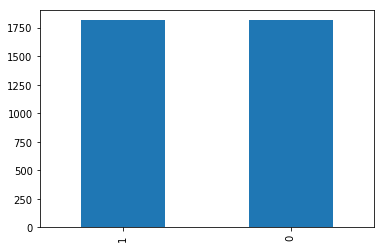

In [0]:
pd.Series(y_train_new).value_counts().plot.bar()

# IV) ML and DL Algo implementation 

# Model 1 - LogisticRegression

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, matthews_corrcoef
clf1=LogisticRegression()

clf1.fit(X_train_new,y_train_new)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:

test_pred_sm=clf1.predict(X_test)

In [0]:
accuracy_score(test_pred_sm,y_test)

0.42857142857142855

In [0]:
matthews_corrcoef(y_test,test_pred_sm)

0.10192730960259795

# Model 2 - Gradient Boosting

In [0]:
from sklearn.ensemble import GradientBoostingClassifier 
clf2=GradientBoostingClassifier()

clf2.fit(X_train_new,y_train_new)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [0]:

test_pred_sm=clf2.predict(X_test)

In [0]:
accuracy_score(test_pred_sm,y_test)

0.9259645464025026

In [0]:
matthews_corrcoef(y_test,test_pred_sm)

0.25989821847826

# Model 3 Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier 
clf3=RandomForestClassifier()

clf3.fit(X_train_new,y_train_new)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:

test_pred_sm=clf3.predict(X_test)

In [0]:
accuracy_score(test_pred_sm,y_test)

0.9343065693430657

In [0]:
matthews_corrcoef(y_test,test_pred_sm)

0.23567787652657735

# Model 4- CNN

In [0]:
X_train_cnn=X_train_new
y_train_cnn=y_train_new
X_test_cnn=X_test
y_test_cnn=y_test.ravel()

In [47]:
print(X_train_cnn.shape)
print(y_train_cnn.shape)
print(X_test_cnn.shape)
print(y_test_cnn.shape)

(3630, 65536)
(3630,)
(959, 65536)
(959,)


In [0]:
img_row,img_col=256,256
X_train_cnn=X_train_cnn.reshape(X_train_cnn.shape[0],img_row,img_col,1).astype('float32')
X_test_cnn=X_test_cnn.reshape(X_test_cnn.shape[0],img_row,img_col,1).astype('float32')

In [0]:
from keras.utils import np_utils
y_train_cnn=np_utils.to_categorical(y_train_cnn,2)
y_test_cnn=np_utils.to_categorical(y_test_cnn,2)

In [0]:
from keras.models import Sequential
from keras.layers import MaxPooling2D, Conv2D, Dropout, Dense, Flatten, Activation, Input
from keras.optimizers import Adam

In [0]:
model=Sequential()

model = Sequential()
model.add(Conv2D(32, (3,3),activation='relu',input_shape=(256,256,1)))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Dropout(0.25)) # For regularization
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

In [58]:
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

model.fit(X_train_cnn,y_train_cnn,batch_size=128,epochs=4,verbose=1)

Epoch 1/4
3630/3630 [==============================] - 8s 2ms/step - loss: 0.0170 - acc: 0.9967
Epoch 2/4
3630/3630 [==============================] - 8s 2ms/step - loss: 0.0098 - acc: 0.9981
Epoch 3/4
3630/3630 [==============================] - 8s 2ms/step - loss: 0.0056 - acc: 0.9992
Epoch 4/4
3630/3630 [==============================] - 8s 2ms/step - loss: 0.0026 - acc: 0.9997


In [0]:
model.evaluate(X_test_cnn,y_test_cnn)


959/959 [==============================] - 22s 23ms/step


[0.3875477317646845, 0.935349322272789]

In [0]:
preds=model.predict_classes(X_test_cnn[:])
y_test_values=y_test_cnn[:,1]

In [61]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(y_test_values,preds)

0.31553836769089144

# Model 5 - Naive Bayes

In [0]:
from sklearn.naive_bayes import GaussianNB
clf5=GaussianNB()
clf5.fit(X_train_new,y_train_new)

GaussianNB(priors=None, var_smoothing=1e-09)

In [0]:
train_pred_nb=clf5.predict(X_train_new)
test_pred_nb=clf5.predict(X_test)

In [0]:
accuracy_score(test_pred_nb,y_test)

0.5933263816475496

In [0]:
matthews_corrcoef(y_test,test_pred_nb)

0.1453285836908005

# Model 6 - LSTM

In [0]:
X_train_lst=X_train_new
y_train_lst=y_train_new
X_test_lst=X_test
y_test_lst=y_test.ravel()

In [0]:
X_train_lst=X_train_lst.reshape(X_train_lst.shape[0],X_train_lst.shape[1],1)
X_test_lst=X_test_lst.reshape(X_test_lst.shape[0],X_test_lst.shape[1],1)

In [0]:
from keras.utils import np_utils
y_train_lst=np_utils.to_categorical(y_train_lst,2)
y_test_lst=np_utils.to_categorical(y_test_lst,2)

In [38]:
print(X_train_lst.shape)
print(y_train_lst.shape)
print(X_test_lst.shape)
print(y_test_lst.shape)

(3630, 65536, 1)
(3630, 2)
(959, 65536, 1)
(959, 2)


In [0]:
from keras.layers import LSTM, Flatten,Dense,Dropout, Bidirectional,GlobalMaxPool1D, CuDNNLSTM
from keras.models import Sequential

model=Sequential()
inp = Input(shape=(65536,1))
x=Bidirectional(CuDNNLSTM(10,return_sequences=True))(inp)
x=Dropout(0.25)(x)
x=Flatten()(x)
x =Dense(100, activation="relu")(x)
x=Dropout(0.25)(x)
x=Dense(2,activation='softmax')(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [30]:
model.fit(X_train_lst,y_train_lst,epochs=3,batch_size=128,verbose=1)

Epoch 1/3
3630/3630 [==============================] - 142s 39ms/step - loss: 2.9380 - acc: 0.7923
Epoch 2/3
3630/3630 [==============================] - 133s 37ms/step - loss: 2.2837 - acc: 0.8485
Epoch 3/3
3630/3630 [==============================] - 133s 37ms/step - loss: 2.8560 - acc: 0.8160


In [0]:
preds=model.predict(X_test_lst[:])
abc=preds[:,1]
abc=np.trunc(abc)

In [0]:
y_test_values=y_test_lst[:,1]

In [97]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(y_test_values,abc)

0.3953005929031948

# Model 7 - Decision tree Classifier

In [0]:
from sklearn.tree import DecisionTreeClassifier
clf7=DecisionTreeClassifier(criterion='entropy')

clf7.fit(X_train_new,y_train_new)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [0]:
test_pred_dt=clf7.predict(X_test)

In [0]:
accuracy_score(test_pred_sm,y_test)

0.8925964546402503

In [0]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(y_test,test_pred_sm)

0.26468314061111897